#### *DIVISIONE DELLE RIGHE CONTENENTI VALORI MULTIPLI*
*Addestramento della rete con dataset del cromosoma 22 e test su dataset del cromosoma 21*  
(Per i commenti guardare file Clean_data21.ipynb)

In [ ]:
from fastai.tabular.all import *
from warnings import simplefilter
import dataframe_image as dfi
set_seed(42)
simplefilter(action="ignore", category=FutureWarning)

In [2]:
df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
df = df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df = df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df.columns:
    if df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df = df.explode(l)
df = df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
df.replace(to_replace='.', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df.columns:
    if df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = df[col].explode().value_counts()
    toRemove = v[v < int(len(df[col].explode()) * 0.10)].index
    df[col] = df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

df_ex = pd.DataFrame.from_dict(dict, orient='index')
df_ex.columns = ['Valori unici', 'Esempi']
print(df_ex)

df.drop(['HPO_id', 'HPO_name', 'MGI_mouse_phenotype'], axis=1, inplace=True)
#dict.pop('Function_description')
#dict.pop('Disease_description')
dict.pop('HPO_id')
dict.pop('HPO_name')
dict.pop('MGI_mouse_phenotype')

for key, value in dict.items():
    if value['Valori unici'] > 10:
        df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            df[c] = df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        df.drop(key, axis=1, inplace=True)

/tmp/ipykernel_2534/3350772352.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


                           Valori unici  \
MutationTaster_score                367   
MutationTaster_pred                   5   
MutationTaster_model                  4   
MutationTaster_AAE                  798   
Gene_other_names                     56   
Uniprot_acc(HGNC/Uniprot)           202   
CCDS_id                             108   
Refseq_id                           114   
Pathway(ConsensusPathDB)             14   
Function_description                  3   
Orphanet_disorder_id                 58   
Orphanet_disorder                    57   
Orphanet_association_type             7   
HPO_id                                1   
HPO_name                              1   
GO_biological_process                10   
GO_cellular_component                10   
GO_molecular_function                16   
MGI_mouse_phenotype                   2   

                                                                                                                                           

In [11]:
df.apply(pd.to_numeric, errors='ignore')
df.replace(to_replace=np.nan, value=0, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'association'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Affects'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'other'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_pathogenic', inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df = df.sample(frac=1).reset_index(drop=True)

In [13]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [14]:
dls = to.dataloaders(bs=1024)

In [15]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=10))

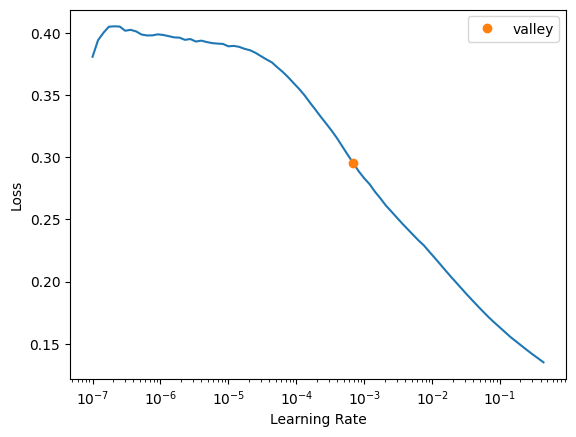

In [16]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.085448,0.096054,0.570692,00:03
1,0.041381,0.012207,0.935650,00:03
2,0.020662,0.008589,0.965116,00:03
3,0.010898,0.007106,0.979255,00:03
4,0.005916,0.007519,0.982690,00:03
5,0.003279,0.007137,0.983351,00:03
6,0.001840,0.008353,0.984144,00:03
7,0.001045,0.008204,0.985994,00:03
8,0.000637,0.008751,0.985729,00:03
9,0.000609,0.008590,0.980444,00:03


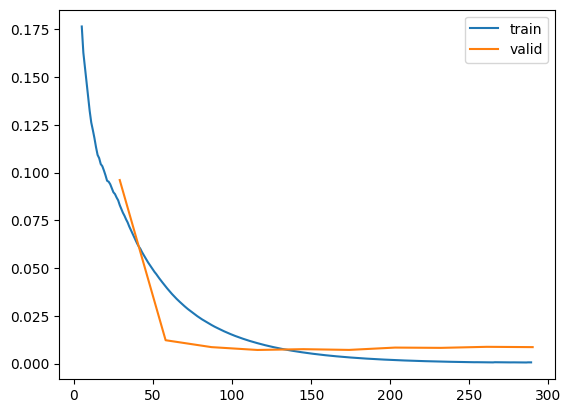

In [17]:
learn.fit(10, 1e-3, wd=0.01)
learn.recorder.plot_loss()

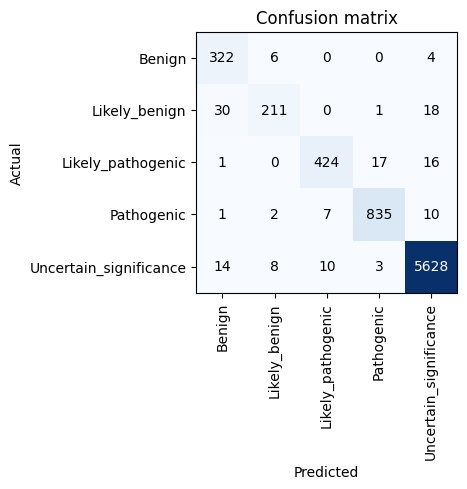

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [19]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators=40, max_samples=3328,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)
     


In [20]:
xs,y = to.train.xs,to.train.y
m = rf(xs, y)

In [21]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [22]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
83,MetaRNN_rankscore,0.258670
82,MetaRNN_score,0.173485
35,clinvar_review,0.070317
84,M-CAP_score,0.051794
85,M-CAP_rankscore,0.050848
134,clinvar_id,0.027216
25,M-CAP_pred,0.025516
67,SIFT4G_converted_rankscore,0.023162
29,ClinPred_pred,0.021277
97,CADD_raw_rankscore,0.019568


<Axes: ylabel='cols'>

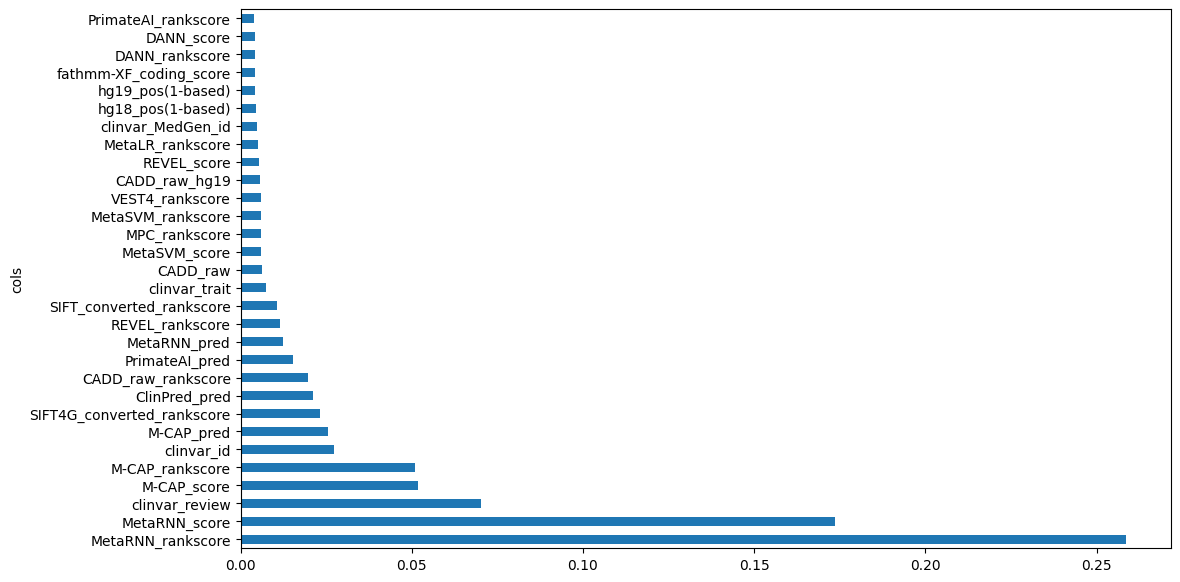

In [23]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

In [24]:
to_keep = fi[fi.imp>0.005].cols

In [25]:
df_keep = df[to_keep].copy()
df_keep

,MetaRNN_rankscore,MetaRNN_score,clinvar_review,M-CAP_score,M-CAP_rankscore,clinvar_id,M-CAP_pred,SIFT4G_converted_rankscore,ClinPred_pred,CADD_raw_rankscore,...,SIFT_converted_rankscore,clinvar_trait,CADD_raw,MetaSVM_score,MPC_rankscore,MetaSVM_rankscore,VEST4_rankscore,CADD_raw_hg19,REVEL_score,MetaLR_rankscore
0,0.79675,0.803002,"criteria_provided,_single_submitter",0.138217,0.82071,571956,D,0.83351,D,0.73166,...,0.91255,Familial_cancer_of_breast,3.832288,0.6942,0.19509,0.93102,0.75101,3.769537,0.703,0.93061
1,0.34828,0.191430,"criteria_provided,_single_submitter",0.045563,0.62042,571620,D,0.45318,T,0.48997,...,0.72154,Familial_cancer_of_breast,2.858785,-0.0862,0.03497,0.80413,0.25867,2.835184,0.446,0.81115
2,0.95529,0.961176,"criteria_provided,_single_submitter",0.178674,0.85372,818448,D,0.92824,D,0.81905,...,0.91255,Hereditary_cancer-predisposing_syndrome,4.094547,0.5943,0.19527,0.91825,0.77413,3.917121,0.883,0.89682
3,0.06850,0.058364,"criteria_provided,_multiple_submitters,_no_conflicts",0.007010,0.18567,590145,T,0.10572,T,0.25542,...,0.08384,Seizures|Familial_focal_epilepsy_with_variable_foci,1.726993,-1.0844,0.39563,0.06517,0.49692,1.827894,0.047,0.13374
4,0.53497,0.371319,"criteria_provided,_single_submitter",0.363779,0.92577,618355,D,0.39799,T,0.41442,...,0.18122,not_provided,2.509201,0.2919,0.00000,0.87428,0.48780,2.732958,0.454,0.88833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37838,0.61790,0.505434,"criteria_provided,_single_submitter",0.583148,0.96271,407093,D,0.83351,D,0.56853,...,0.78490,Primary_dilated_cardiomyopathy,3.210766,-0.7718,0.51227,0.56759,0.47765,2.857525,0.224,0.51722
37839,0.03593,0.045333,"criteria_provided,_conflicting_interpretations",0.052510,0.65101,522164,D,0.18286,T,0.08184,...,0.17014,Inborn_genetic_diseases|not_specified|not_provided,0.414300,-1.0310,0.87627,0.20131,0.06059,0.835910,0.093,0.32353
37840,0.00000,0.000000,"criteria_provided,_multiple_submitters,_no_conflicts",0.000000,0.00000,341972,0,0.00000,0,0.96319,...,0.00000,Renal_hypodysplasia/aplasia_1|not_provided,6.426265,0.0000,0.00000,0.00000,0.26354,6.080596,0.000,0.00000
37841,0.53277,0.368311,"criteria_provided,_single_submitter",0.031596,0.53641,809353,D,0.33780,D,0.80791,...,0.29420,not_provided,4.062887,-0.3685,0.78742,0.73007,0.97317,3.947966,0.272,0.73159


In [26]:
num_cols = df_keep.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_keep.select_dtypes(include=[object]).columns.tolist()
df = pd.concat([df['clinvar_clnsig'], df_keep], axis=1)
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))

In [27]:
to = TabularPandas(df, procs=[Categorify, FillMissing, Normalize],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [28]:
dls = to.dataloaders(bs=1024)

In [29]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=10))

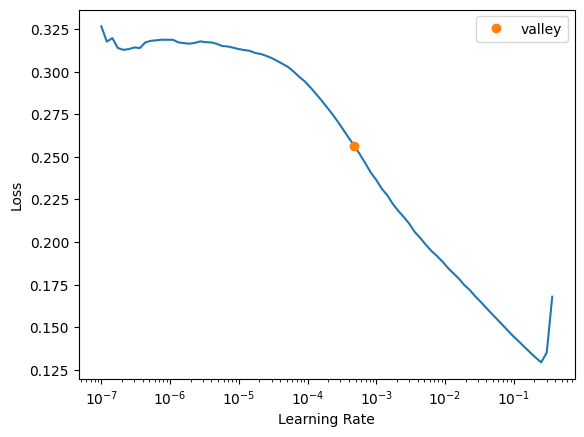

In [30]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.078713,0.097952,0.681158,00:00
1,0.054453,0.034726,0.878171,00:00
2,0.035730,0.014205,0.908695,00:00
3,0.023242,0.009978,0.917151,00:00
4,0.015311,0.006451,0.929704,00:00
5,0.010374,0.005797,0.926401,00:00
6,0.007196,0.004654,0.933140,00:00
7,0.005191,0.005327,0.933536,00:00
8,0.004002,0.004312,0.941200,00:00
9,0.003147,0.003827,0.942521,00:00


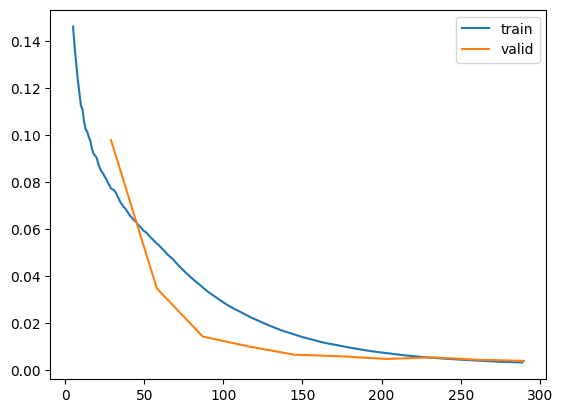

In [31]:
learn.fit(10, 1e-3, wd=0.01)
learn.recorder.plot_loss()

In [32]:
test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
test_df = test_df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
test_df = test_df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in test_df.columns:
    if test_df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(test_df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
test_df = test_df.explode(l)
test_df = test_df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.dropna(axis='columns', thresh=int(len(test_df.index)*0.8), inplace=True)
test_df = test_df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in test_df.columns:
    if test_df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = test_df[col].explode().value_counts()
    toRemove = v[v < int(len(test_df[col].explode()) * 0.10)].index
    test_df[col] = test_df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = test_df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

test_df.drop(['Function_description', 'Disease_description', 'HPO_id', 'HPO_name', 'MGI_mouse_phenotype'], axis=1, inplace=True)
dict.pop('Function_description')
dict.pop('Disease_description')
dict.pop('HPO_id')
dict.pop('HPO_name')
dict.pop('MGI_mouse_phenotype')

for key, value in dict.items():
    if value['Valori unici'] > 10:
        test_df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(test_df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            test_df[c] = test_df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        test_df.drop(key, axis=1, inplace=True)

/tmp/ipykernel_2534/2111471915.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


In [33]:
cols = [col for col in df.columns if col not in test_df.columns]
for col in cols:
    test_df[col] = 0

cols = [col for col in df.columns if col in test_df.columns]
test_df = test_df[cols]

test_df.apply(pd.to_numeric, errors='ignore')
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
test_df.replace(to_replace=np.nan, value=0, inplace=True)
test_df.reset_index(drop=True, inplace=True)
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

(#2) [0.061124302446842194,0.7670221924781799]

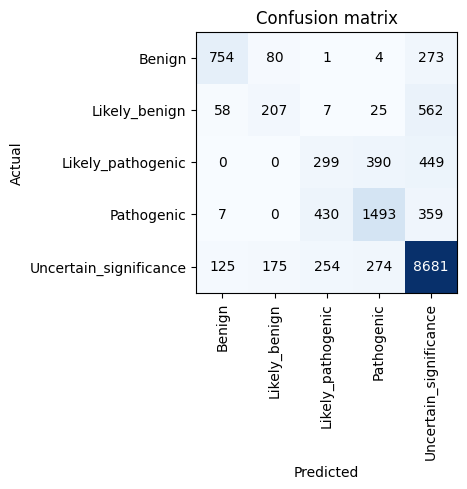

In [34]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()